In [1]:
import os

In [2]:
data_dir = 'D:\\cell_images'

os.listdir(data_dir)

['test', 'train']

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [4]:
test_path = data_dir+'\\test\\'
train_path = data_dir+'\\train\\'

In [5]:
test_path

'D:\\cell_images\\test\\'

In [6]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [7]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [8]:
os.listdir(train_path+'parasitized')[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [9]:
para_cell = train_path+'parasitized\\'+'C100P61ThinF_IMG_20150918_144104_cell_162.png'
para_cell

'D:\\cell_images\\train\\parasitized\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [10]:
imread(para_cell).shape

(148, 142, 3)

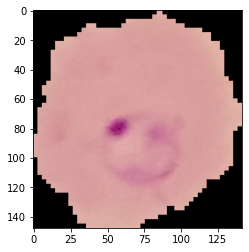

In [11]:
plt.imshow(imread(para_cell));

In [12]:
os.listdir(train_path+'uninfected')[0]

'C100P61ThinF_IMG_20150918_144104_cell_128.png'

In [13]:
uninfected_cell = train_path+'uninfected\\'+'C100P61ThinF_IMG_20150918_144104_cell_128.png'
uninfected_cell = imread(uninfected_cell)

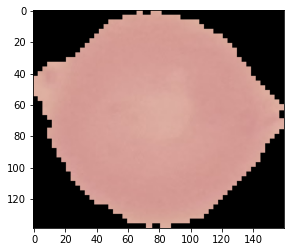

In [14]:
plt.imshow(uninfected_cell);

In [15]:
print(len(os.listdir(train_path+'parasitized')))
print(len(os.listdir(train_path+'uninfected')))

12480
12480


In [16]:
print(len(os.listdir(test_path+'uninfected')))
print(len(os.listdir(test_path+'uninfected')))

1300
1300


In [17]:
dim1 = []
dim2 = []

# loop through and get image name for each file in directory
for image_filename in os.listdir(test_path+'uninfected'):

    img = imread(test_path+'uninfected\\'+image_filename) # pass in image name along with file path
    # add dimensions to lists
    d1, d2, colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

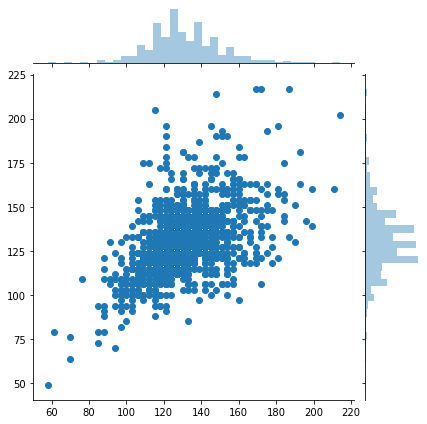

In [18]:
sns.jointplot(dim1, dim2);

In [19]:
print(np.mean(dim1))
print(np.mean(dim2))

130.92538461538462
130.75


In [20]:
image_shape = (130, 130, 3)

In [21]:
# image is already scaled
imread(para_cell).max()

0.9098039

In [22]:
# image is already scaled
uninfected_cell.max()

0.88235295

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1,
                               height_shift_range=0.1, shear_range=0.1,
                               zoom_range=0.1, horizontal_flip=True,
                               fill_mode='nearest')

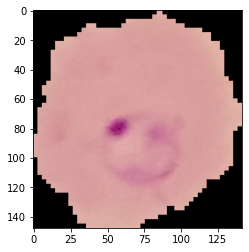

In [24]:
para_img = imread(para_cell)
plt.imshow(imread(para_cell));

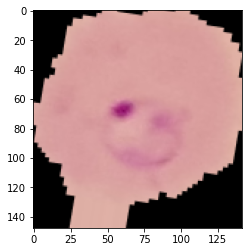

In [25]:
plt.imshow(image_gen.random_transform(para_img));

In [26]:
# Images must be organized into sub-directories for image generator to work!
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [27]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D,Dropout, Flatten

model = Sequential()
# image_shape defined in above code as average of the dimensions
model.add(Conv2D(filters=32, kernel_size=(3, 3),input_shape=image_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3),input_shape=image_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3),input_shape=image_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [31]:
batch_size=16

# target_size comes from image_size, which is average dimensions of the images
# we only want the width and height, so use list slicing to return only those
train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='binary')

Found 24958 images belonging to 2 classes.


In [32]:
# shuffle=False when on test images
test_image_gen = image_gen.flow_from_directory(test_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='binary',
                                               shuffle=False)

Found 2600 images belonging to 2 classes.


In [33]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [34]:
results = model.fit_generator(train_image_gen, epochs=20,
                              validation_data=test_image_gen,
                              callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
1560/1560 [==============================] - 91s 58ms/step - loss: 0.8597 - accuracy: 0.5611 - val_loss: 0.6894 - val_accuracy: 0.5338

In [35]:
pred = model.predict_generator(test_image_gen)

Instructions for updating:
Please use Model.predict, which supports generators.


In [36]:
# pred returns probabilities. Turn into bool array, interpreted as 1 and 0 by numpy
# adjustable threshold, to improve precision and recall.
predictions = pred > 0.5

array([[6.904812e-04],
       [3.050130e-05],
       [8.794535e-05],
       ...,
       [9.861507e-01],
       [9.961159e-01],
       [9.797887e-01]], dtype=float32)

In [38]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(test_image_gen.classes), predictions)

TypeError: classification_report() missing 1 required positional argument: 'y_pred'

In [39]:
confusion_matrix(test_image_gen.classes, predictions)

NameError: name 'predictions' is not defined

In [41]:
from tensorflow.keras.preprocessing import image

my_image = image.load_img(image.load_img(para_cell, target_size=image_shape))

TypeError: expected str, bytes or os.PathLike object, not Image

In [42]:
my_image

NameError: name 'my_image' is not defined

In [43]:
my_img_arr = image.img_to_array(my_image)

NameError: name 'my_image' is not defined

In [45]:

my_img_arr.shape

NameError: name 'my_img_arr' is not defined

In [ ]:
# my_img_arr should be (1, 130, 130, 3). It needs to know the number of images(batches)
np.expand_dims(my_img_arr, axis=0)

In [46]:
model.predict(my_img_arr)

NameError: name 'my_img_arr' is not defined

In [47]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}